In [52]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage import gaussian_filter
import cv2

In [53]:

def visualize(arr: np.array, cmap: str = "viridis", flip: bool = False):
    img = np.copy(arr)
    img = img - img.min()
    img = img / img.max()
    plt.imshow(img, cmap=cmap, origin="upper")


def magnitude2(arrX: np.array, arrY: np.array):
    return np.sqrt(arrX**2 + arrY**2)


def interp2d(a, x, y):
    X = np.floor(x).astype(int)
    Y = np.floor(y).astype(int)
    fracX = x - X
    fracY = y - Y
    X = np.clip(X, 0, a.shape[0] - 2)
    Y = np.clip(Y, 0, a.shape[1] - 2)


    U1 = (1.0 - fracX) * a[X + 0, Y + 0] + fracX * a[X + 1, Y + 0]
    U2 = (1.0 - fracX) * a[X + 0, Y + 1] + fracX * a[X + 1, Y + 1]
    U = (1.0 - fracY) * U1 + fracY * U2
    return U

-47.948433
43.387325
-44.557438
41.64138
0.0
48.01531


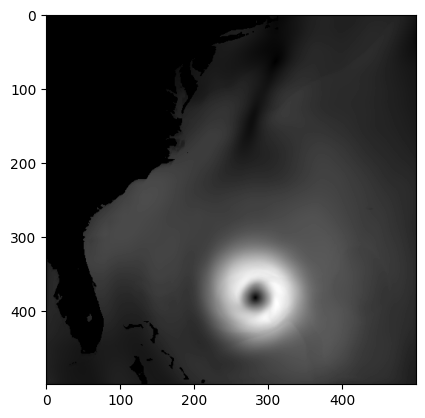

In [64]:
d1 = h5py.File("../isabel_2d.h5", "r")
u = np.array(d1["Velocity"]["X-comp"])
v = np.array(d1["Velocity"]["Y-comp"])
V = magnitude2(u, v)
# u = cv2.resize(u, (500, 500))
# v = cv2.resize(v, (500, 500))
mag = magnitude2(u, v)
img = np.dstack([u, v, np.zeros_like(u)])
mesh_size = u.shape[0]
visualize(magnitude2(u, v))

print(np.min(u))
print(np.max(u))
print(np.min(v))
print(np.max(v))
print(np.min(mag))
print(np.max(mag))

minMag = 0.0
maxMag = 48.02

mag = np.sqrt(u**2+v**2)
mag = (mag - minMag)/(minMag+maxMag)
plt.imshow(mag, 'grey')

In [56]:
U = np.copy(u)
V = np.copy(v)
MAG = np.copy(mag)

U = U - np.min(U)
U = U/np.max(U)

V = V - np.min(V)
V = V/np.max(V)

MAG = MAG - np.min(MAG)
MAG= MAG/np.max(MAG)

mask = np.ones_like(V)

cv2.imwrite('u_metsim.png', U*255)
cv2.imwrite('v_metsim.png', V*255)
cv2.imwrite('mag_metsim.png', MAG*255)

True

In [57]:
i = np.arange(0, mesh_size).astype(float)
j = np.arange(0, mesh_size).astype(float)
ii, jj = np.meshgrid(i, j)

In [58]:
# generate noise texture
n = np.random.random(u.shape)

arc_length = 50
step_size = 0.2 

# perform LIC
l = int(round(arc_length/step_size))
h = np.exp(-np.linspace(-2, 2, l)**2)  

#h /= h.sum()
#kernel_magnitude = sum(h)
#plt.plot(np.arange(len(h)), h)

In [59]:
cv2.imwrite('noise_metsim.png', n*255)

True

In [60]:

# hold result
F = np.zeros_like(n)
# convolve initial positions
F = interp2d(n, ii, jj)
kernel_mag = np.zeros_like(F)

# fwd steps
xx, yy = ii, jj
for k in range(1, l):
    u_local = interp2d(u, xx, yy)
    v_local = interp2d(v, xx, yy)
    mag_local = np.sqrt(u_local**2 + v_local**2) + 1e-32

    dtx = step_size * u_local / mag_local
    dty = step_size * v_local / mag_local

    xx += dtx
    yy += dty
    F += interp2d(n, xx, yy)
    print(f"{k}/{l}")

# bwd steps
xx, yy = ii, jj
for k in range(1, l):
    u_local = interp2d(u, xx, yy)
    v_local = interp2d(v, xx, yy)
    mag_local = np.sqrt(u_local**2 + v_local**2) + 1e-32

    dtx = step_size * u_local / mag_local
    dty = step_size * v_local / mag_local

    xx -= dtx
    yy -= dty

    F += interp2d(n, xx, yy)
    print(f"{k}/{l}")

1/250
2/250
3/250
4/250
5/250
6/250
7/250
8/250
9/250
10/250
11/250
12/250
13/250
14/250
15/250
16/250
17/250
18/250
19/250
20/250
21/250
22/250
23/250
24/250
25/250
26/250
27/250
28/250
29/250
30/250
31/250
32/250
33/250
34/250
35/250
36/250
37/250
38/250
39/250
40/250
41/250
42/250
43/250
44/250
45/250
46/250
47/250
48/250
49/250
50/250
51/250
52/250
53/250
54/250
55/250
56/250
57/250
58/250
59/250
60/250
61/250
62/250
63/250
64/250
65/250
66/250
67/250
68/250
69/250
70/250
71/250
72/250
73/250
74/250
75/250
76/250
77/250
78/250
79/250
80/250
81/250
82/250
83/250
84/250
85/250
86/250
87/250
88/250
89/250
90/250
91/250
92/250
93/250
94/250
95/250
96/250
97/250
98/250
99/250
100/250
101/250
102/250
103/250
104/250
105/250
106/250
107/250
108/250
109/250
110/250
111/250
112/250
113/250
114/250


KeyboardInterrupt: 

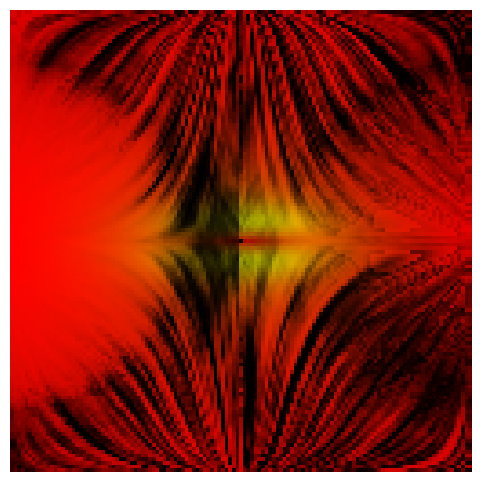

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_facecolor("black")
ax.set_axis_off()

# normalize lic result
F_proc = np.copy(F.T)
F_proc[mag < 0.01] = 0.0
plt.imshow(F_proc, 'grey')
F_proc -= F_proc.min()
F_proc /= F_proc.max()

# Apply histogram equalization
F_eq = np.copy(F_proc)
F_eq *= 255
F_eq = F_eq.astype(np.uint8)
F_eq = cv2.equalizeHist(F_eq)
F_eq = (F_eq/255.0).astype(np.float32)

mag_proc = np.copy(mag)
mag_proc -= mag_proc.min()
mag_proc /= mag_proc.max()

cmap = plt.cm.autumn(mag_proc)

cmap[..., :3] *= F_eq[..., np.newaxis]
plt.imshow(cmap) 

plt.show()

In [ ]:
mag

array([[0.01544602, 0.02191759, 0.02968667, ..., 0.02971109, 0.02193953,
        0.01546155],
       [0.02667845, 0.0309195 , 0.03689903, ..., 0.03697765, 0.03098182,
        0.02671446],
       [0.03869571, 0.04178648, 0.04647463, ..., 0.04661502, 0.04189025,
        0.03875158],
       ...,
       [0.03870919, 0.04183631, 0.04657517, ..., 0.04671517, 0.04193996,
        0.03876509],
       [0.02669137, 0.03096407, 0.03698288, ..., 0.03706125, 0.03102632,
        0.02672739],
       [0.01545711, 0.02194889, 0.02973858, ..., 0.02976291, 0.02197082,
        0.01547265]], dtype=float32)

In [ ]:
np.max(F_proc)

np.float64(1.0)